In [1]:
%load_ext autoreload
%autoreload 2

import os

import copy

import numpy as np
import matplotlib.pyplot as plt

from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, hstack

from mrf.display import display_single, SEG_CMAP, draw_circles
from mrf.utils import img_cutout, extract_obj
from mrf.celestial import Celestial, Star
import sep

plt.rcParams['text.usetex'] = True

In /anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.

### Download DECaLS images and crop

In [3]:
from mrf.download import download_decals_cutout
#from kuaizi.download import download_decals_cutout
download_decals_cutout(226.3341906, 1.8119113, 180, 'g', layer='dr8', pixel_unit=False, output_name='decals')
# This larger one is used to get a better PSF
download_decals_cutout(226.3341906, 1.8119113, 400, 'g', layer='dr8', pixel_unit=False, output_name='decals_large')

decals_g.fits: 1.89MB [00:04, 382kB/s]                             
decals_large_g.fits: 0.00B [00:00, ?B/s]

# Downloading decals_g.fits finished! 


decals_large_g.fits: 9.34MB [00:11, 820kB/s]                             

# Downloading decals_large_g.fits finished! 


In [4]:
## Crop HST images
#hdu = fits.open('./hst_16284_01_wfc3_uvis_f475w_iedd01_drc.fits')
hdu = fits.open('./im_f475w_mbg_large.fits') # This file is (and must be) bkg-subtracted!
img = hdu[0].data.byteswap().newbyteorder()
bkg = sep.Background(img)
bkg.subfrom(img)
_ = img_cutout(img, wcs.WCS(hdu[0].header), 226.3346588, 1.8123696, size=[180, 180], pixel_scale=0.04, prefix='hst_g')

In [5]:
#hdu = fits.open('./hst_16284_01_wfc3_uvis_f606w_iedd01_drc.fits')
hdu = fits.open('./im_f606w_mbg_large.fits')
img = hdu[0].data.byteswap().newbyteorder()
bkg = sep.Background(img)
bkg.subfrom(img)
_ = img_cutout(img, wcs.WCS(hdu[0].header), 226.3346588, 1.8123696, size=[180, 180], pixel_scale=0.04, prefix='hst_r')

### Working on deriving DECaLS PSF. 
Since the small DECaLS cutout doesn't have enough bright stars, we need to work on the larger DECaLS cutout to get a better DECaLS PSF.

In [2]:
img = fits.open('decals_large_g.fits')[0].data
hdr = fits.open('decals_large_g.fits')[0].header

# Detect 1302 objects


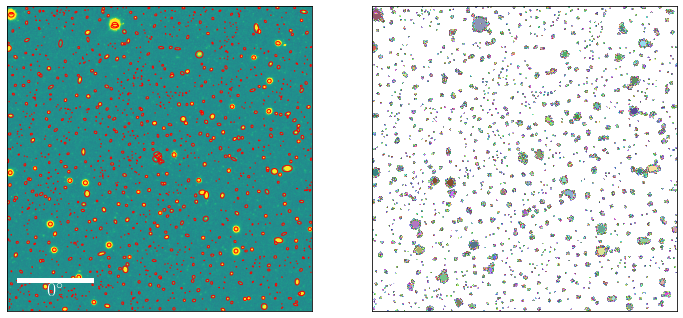

In [3]:
objects, segmap = extract_obj(
    img,
    b=32,
    f=3,
    sigma=2.5,
    minarea=3,
    deblend_nthresh=32,
    deblend_cont=0.003,
    sky_subtract=True,
    show_fig=True,
    flux_aper=[15, 20],
)
objects.sort(keys='flux', reverse=True)

psf_cat = objects[:40]
mag = 22.5 - 2.5 * np.log10(psf_cat['flux'])
psf_cat.add_column(Column(data=mag, name='mag'))
psf_cat = psf_cat[psf_cat['b'] / psf_cat['a'] > 0.9]
psf_cat = psf_cat[psf_cat['mag'] < 20.5]

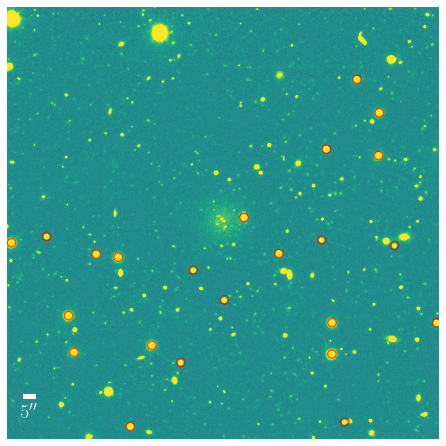

In [4]:
draw_circles(img, psf_cat)

In [5]:
with open('./ngc5846-udg1-task-decals-g.yaml', 'r') as ymlfile:
    import yaml
    from mrf.task import Config
    cfg = yaml.safe_load(ymlfile)
    config = Config(cfg)
    config.complete_config() # auto-complete absent keywords

In [6]:
# Construct and stack `Stars`.
size = 2 * config.starhalo.halosize + 1
stack_set = np.zeros((len(psf_cat), size, size))
bad_indices = []
for i, obj in enumerate(psf_cat):
    try:
        sstar = Star(img, header=hdr, starobj=obj, 
                     halosize=config.starhalo.halosize, padsize=config.starhalo.padsize)
        cval = config.starhalo.cval
        if isinstance(cval, str) and 'nan' in cval.lower():
            cval = np.nan
        else:
            cval = float(cval)

        sstar.centralize(method=config.starhalo.interp)

        if config.starhalo.mask_contam is True:
            sstar.mask_out_contam(sigma=4.0, deblend_cont=0.0001, show_fig=False, verbose=False)
        if config.starhalo.norm == 'flux_ann':
            stack_set[i, :, :] = sstar.get_masked_image(cval=cval) / sstar.fluxann
        else:
            stack_set[i, :, :] = sstar.get_masked_image(cval=cval) / sstar.flux

    except Exception as e:
        stack_set[i, :, :] = np.ones((size, size)) * 1e9
        bad_indices.append(i)
        print(e)

In [7]:
from mrf.utils import psf_bkgsub
from astropy.stats import sigma_clip
from astropy.convolution import convolve, Box2DKernel

stack_set = np.delete(stack_set, bad_indices, axis=0)
median_psf = np.nanmedian(stack_set, axis=0)
median_psf = psf_bkgsub(median_psf, int(config.starhalo.edgesize))
median_psf = convolve(median_psf, Box2DKernel(2))
sclip = sigma_clip(stack_set, axis=0, maxiters=3)
sclip[sclip.mask] = np.nan

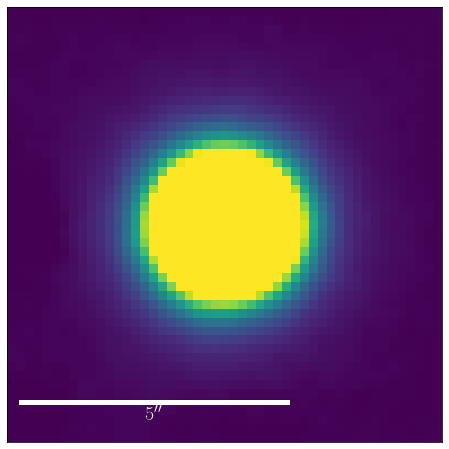

In [8]:
display_single(median_psf);

In [14]:
from mrf.utils import save_to_fits
save_to_fits(median_psf, 'median_psf_g.fits')

In [11]:
median_psf.shape

(49, 49)

### Implement `mrf` task

In [12]:
from mrf.task import MrfTask
from astropy.convolution import Gaussian2DKernel
from mrf.utils import bright_star_mask

In [15]:
task = MrfTask('ngc5846-udg1-task-decals-g.yaml')
img_lowres = 'decals_g.fits'
img_hires_b = 'hst_g.fits'
img_hires_r = 'hst_r.fits'
certain_gal_cat = None
median_psf_file = './median_psf_g.fits'
results = task.run(img_lowres, img_hires_b, img_hires_r, certain_gal_cat, median_psf_file=median_psf_file, 
                   wide_psf=False, output_name='n5846_g', verbose=True, skip_resize=False, skip_SE=False, skip_mast=False)

2021-01-11 20:01:50,189 Running Multi-Resolution Filtering (MRF) on "hst" and "decals" images!
2021-01-11 20:01:50,207 Magnify Dragonfly image with a factor of 3.0:
2021-01-11 20:01:51,741 Register high resolution image "hst_g.fits" with "decals_g.fits"
2021-01-11 20:01:55,079 Register high resolution image "hst_r.fits" with "decals_g.fits"
2021-01-11 20:01:58,145 Build flux models on high-resolution images: Blue band
2021-01-11 20:01:58,145     - sigma = 2.5, minarea = 2
2021-01-11 20:01:58,146     - deblend_cont = 0.00500, deblend_nthres = 32.0
2021-01-11 20:01:58,663     - Detect 2994 objects
2021-01-11 20:01:59,234 Build flux models on high-resolution images: Red band
2021-01-11 20:01:59,235     - sigma = 2.5, minarea = 2
2021-01-11 20:01:59,236     - deblend_cont = 0.00500, deblend_nthres = 32.0
2021-01-11 20:01:59,715     - Detect 2700 objects
2021-01-11 20:02:00,339 Make color correction to blue band, remove artifacts as well
2021-01-11 20:02:00,457     - color_term = 0.05
2021-

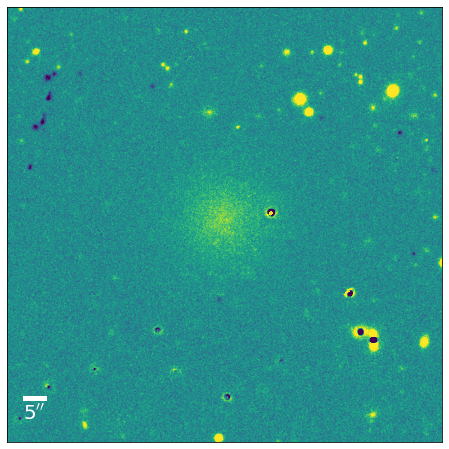

In [38]:
display_single(fits.open('./n5846_halosub.fits')[0].data);

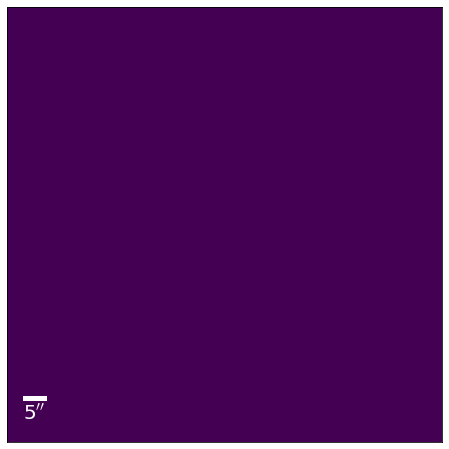

In [17]:
display_single(results.lowres_final_unmask.image - fits.open('/Users/jiaxuanli/Downloads/n5846_halosub (1).fits')[0].data);

## Make a nice mask for this object

In [18]:
# Mask out compact sources, but dont mask the UDG itself (by drawing a circle centered at UDG)
model_mask = convolve(1e3 * results.lowres_model_compact.image / np.nansum(results.lowres_model_compact.image),
                      Gaussian2DKernel(1.5))
model_mask[model_mask < 0.01] = 0
model_mask[model_mask != 0] = 1

footprint = np.zeros_like(model_mask, dtype=bool)
sep.mask_ellipse(footprint, 343, 343, 20, 20, 0, r=4)
model_mask[footprint] = 0

# Mask out bright stars
totmask = bright_star_mask(model_mask.astype(bool), results.bright_star_cat, 
                           bright_lim=19.5, 
                           r=5)
totmask = convolve(totmask.astype(float), Box2DKernel(2))
totmask[totmask > 0] = 1

save_to_fits(totmask, 'n5846_g_slight_mask.fits', header=results.lowres_final.header)

img_slight_masked = results.lowres_final_unmask.image * (~totmask.astype(bool))

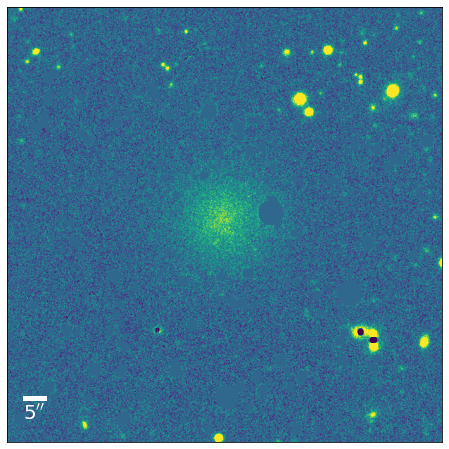

In [19]:
display_single(img_slight_masked);

# Detect 78 objects


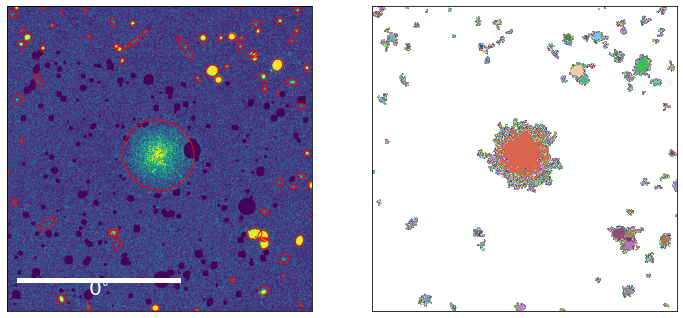

In [20]:
## Also mask out other objects, which are not in the footprint of HST image

objects, segmap = extract_obj(
    np.abs(img_slight_masked),
    b=128,
    f=3,
    sigma=2.5,
    minarea=3,
    deblend_nthresh=32,
    deblend_cont=0.01,
    sky_subtract=True,
    show_fig=True,
    flux_aper=[15, 20],
)
objects.sort(keys='flux', reverse=True)
cen_y, cen_x = np.array(img_slight_masked.shape) // 2

segmap[segmap == segmap[cen_y, cen_x]] = 0
large_mask = (segmap != 0)
large_mask = convolve(large_mask, Gaussian2DKernel(1.5))
large_mask[large_mask < 0.2] = 0
large_mask[large_mask != 0] = 1

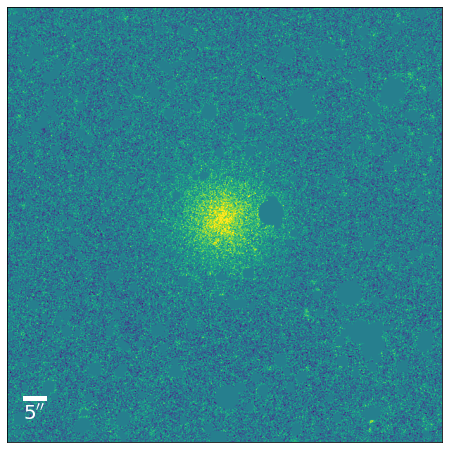

In [21]:
display_single(img_slight_masked * (~large_mask.astype(bool)));

In [22]:
save_to_fits(large_mask + totmask, 'n5846_g_full_mask.fits', header=results.lowres_final.header)

In [24]:
### Pymfit needs a INV-VAR matrix, here I simply estimate it as follows

save_to_fits(1 / np.sqrt(np.abs(
    results.lowres_final_unmask.
    image)), 'n5846_g_invvar.fits', header = results.lowres_final.header)

### Display

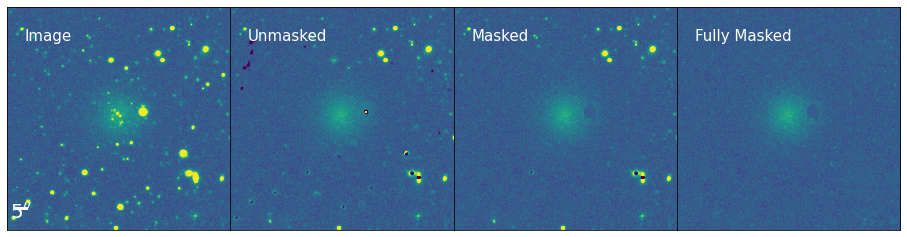

In [25]:
from mrf.display import display_multiple
display_multiple(
    [
        results.lowres_input.image,
        results.lowres_final_unmask.image,
        img_slight_masked,
        img_slight_masked *
        (~large_mask.astype(bool))  #results.lowres_final.image
    ],
    text=['Image', 'Unmasked', 'Masked', 'Fully Masked'],
    text_fontsize=15,
    text_y_offset=0.9);

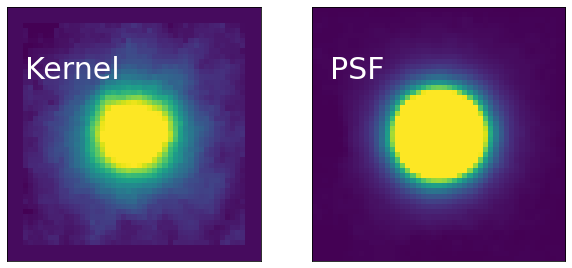

In [26]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
ax1 = display_single(results.kernel_med, ax=ax1, 
                     scale_bar=False, add_text='Kernel')
ax2 = display_single(results.PSF, ax=ax2, 
                     scale_bar=False, add_text='PSF')